In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


Covariance Matrix:
[[ 6.15299068e+05 -5.39451485e-11]
 [-5.39451485e-11  5.36835063e+05]]

Mean of the data:
[5.23320364e-14 2.70682947e-15]
Converged in 9 iterations!


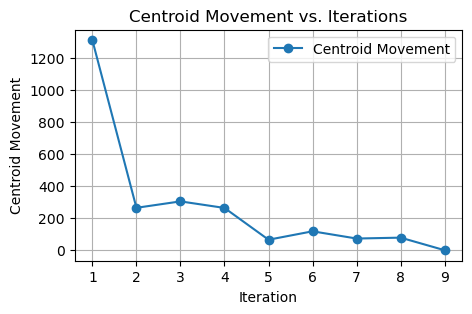

Covariance Matrix:
[[ 6.15299068e+05 -5.39451485e-11]
 [-5.39451485e-11  5.36835063e+05]]

Mean of the data:
[5.23320364e-14 2.70682947e-15]
Converged in 12 iterations!


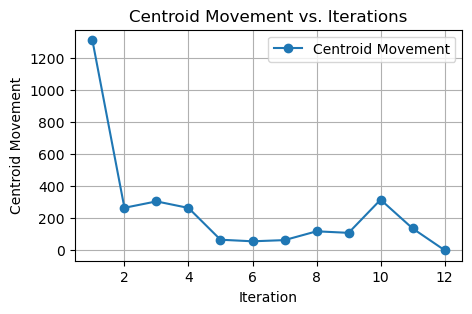

In [3]:
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Parameters
train_folder = 'desktop/internship/dataset/group05/Train'  # Update with your training dataset folder
test_folder = 'desktop/internship/dataset/group05/Test'  # Update with your test dataset folder
n_clusters = 3  # Number of clusters for K-means
resize_shape = (128, 128)  # Resize shape for all images

# Function to load and preprocess images
def load_images(folder_path, resize_shape):
    images = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath) and filename.endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, resize_shape)
            images.append(image.flatten())
    return np.array(images)

# Define the Mahalanobis distance
def mahalanobis_dist(x1, x2, cov_matrix):
    mean_diff = x1 - x2
    cov_matrix_inv = np.linalg.inv(cov_matrix)
    distance = np.sqrt(np.dot(np.dot(mean_diff.T, cov_matrix_inv), mean_diff))
    return distance

# Define the KMeans clustering function
def KMeansClustering(X, K, maxIteration, mod: bool, tolerance=1e-4):
    m = X.shape[0]
    np.random.seed(42)
    centroids = X[np.random.choice(m, K, replace=False)]
    idx = np.zeros(m, dtype=int)
    prevCentroid = np.zeros_like(centroids)
    cov = np.cov(X, rowvar=False)

    print("Covariance Matrix:")
    print(cov)
    print("\nMean of the data:")
    print(np.mean(X, axis=0))

    iteration_list = []
    centroid_movements = []

    for i in range(maxIteration):
        if mod:
            dist = np.zeros((m, K))
            for j in range(m):
                for k in range(K):
                    dist[j, k] = mahalanobis_dist(X[j], centroids[k], cov)
        else:
            dist = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

        idx = np.argmin(dist, axis=1)
        prevCentroid = centroids.copy()

        for k in range(K):
            points = X[idx == k]
            if len(points) > 0:
                centroids[k] = np.mean(points, axis=0)

        centroid_movement = np.linalg.norm(centroids - prevCentroid)
        iteration_list.append(i + 1)
        centroid_movements.append(centroid_movement)

        if centroid_movement < tolerance:
            print(f"Converged in {i + 1} iterations!")
            break

    # Plot the centroid movement
    plt.figure(figsize=(5, 3))
    plt.plot(iteration_list, centroid_movements, marker='o', label="Centroid Movement")
    plt.title("Centroid Movement vs. Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Centroid Movement")
    plt.grid(True)
    plt.legend()
    plt.show()

    return centroids, idx

# Function to restore and visualize centroid images with sharp details and clear colors
def visualize_centroid_images_sharp(centroids, pca, title_prefix, original_shape):
    for i, p in enumerate(centroids):
        # Transform centroid back to original dimensions
        tp = pca.inverse_transform(p)
        restored_image = tp.reshape(original_shape)  # Adjust shape to your dataset

        # Normalize the restored image to the range [0, 1]
        normalized_image = (restored_image - restored_image.min()) / (restored_image.max() - restored_image.min())

        # Enhance contrast to ensure sharp and clear details
        sharp_image = np.clip(normalized_image * 1.5, 0, 1)

        # Use a colormap for better visualization
        plt.imshow(sharp_image, cmap='plasma')
        plt.colorbar()  # Add a color bar for better interpretation
        plt.title(f"{title_prefix} Centroid {i + 1}")
        plt.axis("off")
        plt.show()

if __name__ == "__main__":
    # Load and preprocess training and testing images
    train_images = load_images(train_folder, resize_shape)
    test_images = load_images(test_folder, resize_shape)

    # Combine datasets for clustering
    all_images = np.vstack((train_images, test_images))

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(all_images)

    # Perform KMeans clustering with Euclidean distance
    centroidEuclid, idxEuclid = KMeansClustering(X_pca, K=n_clusters, maxIteration=100, mod=False)

    # Perform KMeans clustering with Mahalanobis distance
    centroidMahalanobis, idxMahalanobis = KMeansClustering(X_pca, K=n_clusters, maxIteration=100, mod=True)


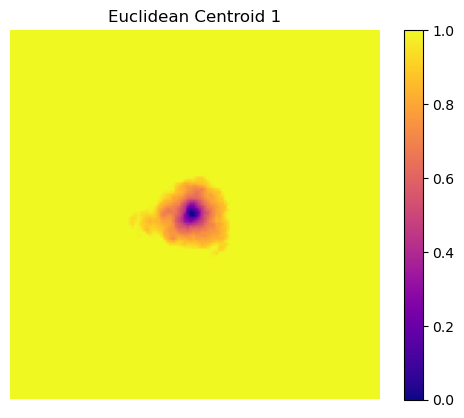

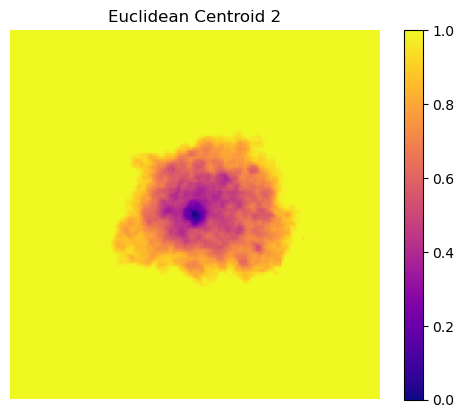

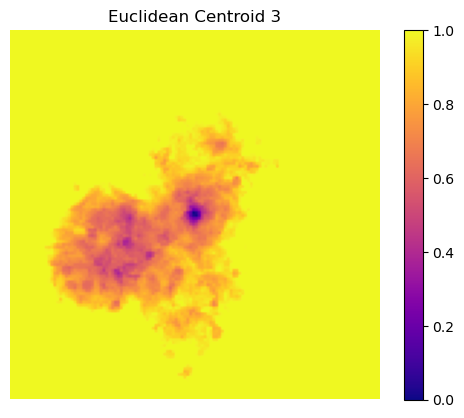

In [7]:
if __name__ == "__main__":
      visualize_centroid_images_sharp(centroidEuclid, pca, "Euclidean", resize_shape)

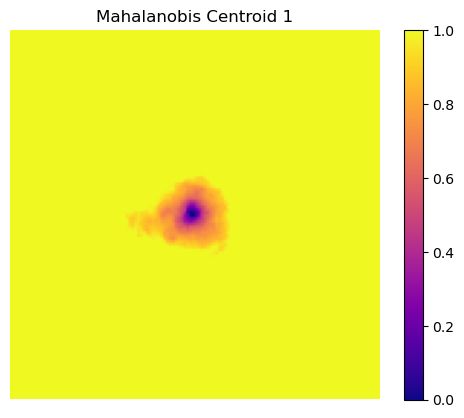

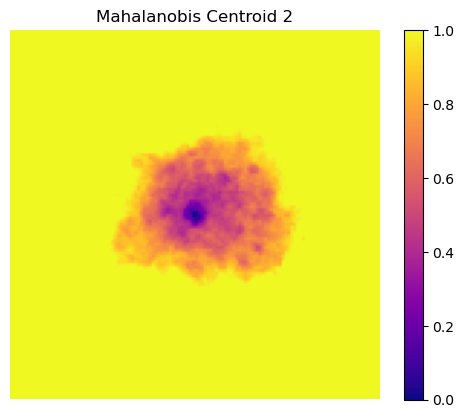

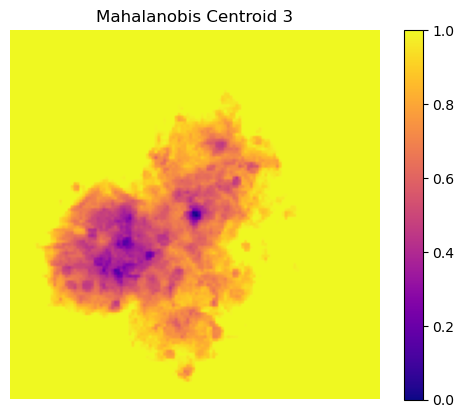

In [8]:
if __name__ == "__main__":
    visualize_centroid_images_sharp(centroidMahalanobis, pca, "Mahalanobis", resize_shape)

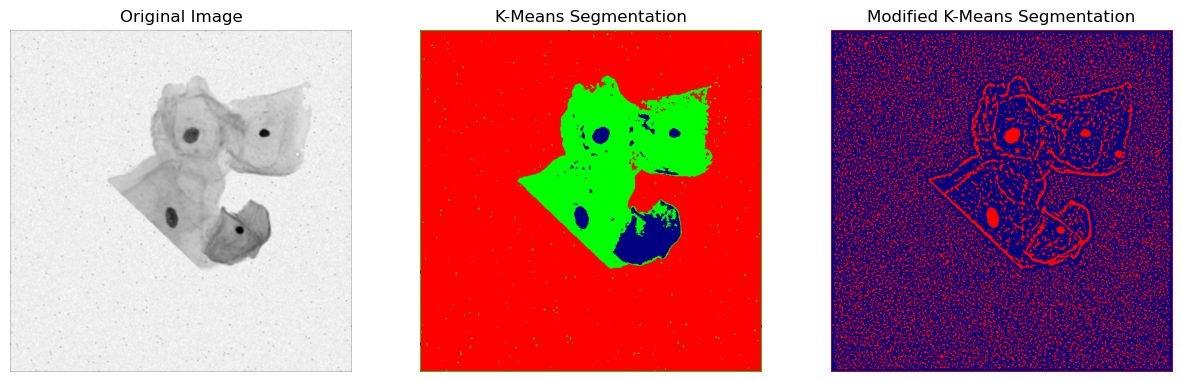

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image (Update with your actual filename)
image_path = "desktop/internship/dataset/group05/test/13.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Ensure the image is loaded correctly
if image is None:
    raise ValueError("Error loading the image. Check the file path and filename.")

# Apply K-Means Clustering for segmentation
Z = image.reshape((-1, 1))
Z = np.float32(Z)

# Define criteria, number of clusters (K), and apply K-Means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # Number of clusters
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Reshape labels back to image dimensions
segmented_image = labels.reshape(image.shape)

# Assign colors to the segmented regions
colors = np.array([[0, 0, 128], [255, 0, 0], [0, 255, 0]], dtype=np.uint8)  # Background (blue), Cytoplasm (red), Nuclei (green)
segmented_image_colored = colors[segmented_image]

# Improve segmentation by detecting nuclei with adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

# Create an empty segmentation map
modified_segmentation = np.zeros_like(segmented_image_colored)

# Assign colors: Background (blue), Cytoplasm (red), Nucleus (green)
modified_segmentation[adaptive_thresh == 255] = [0, 255, 0]  # Green for nuclei
modified_segmentation[adaptive_thresh == 0] = [0, 0, 128]  # Blue for background

# Detect cell contours and mark cytoplasm
contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(modified_segmentation, contours, -1, (255, 0, 0), thickness=cv2.FILLED)  # Red for cytoplasm

# Display the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(segmented_image_colored)
axs[1].set_title("K-Means Segmentation")
axs[1].axis("off")

axs[2].imshow(modified_segmentation)
axs[2].set_title("Modified K-Means Segmentation")
axs[2].axis("off")

plt.show()

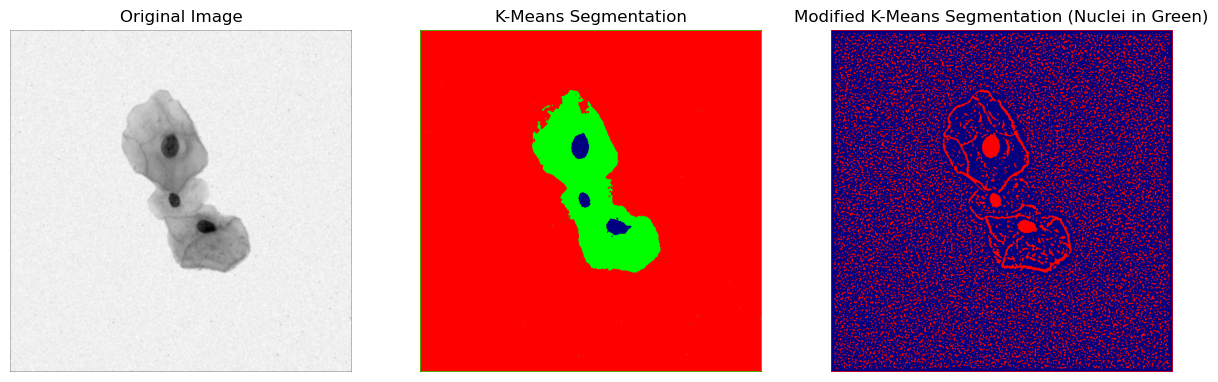

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image (Update with your actual filename)
image_path = "desktop/internship/dataset/group05/test/53.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Ensure the image is loaded correctly
if image is None:
    raise ValueError("Error loading the image. Check the file path and filename.")

# Apply K-Means Clustering for segmentation
Z = image.reshape((-1, 1))
Z = np.float32(Z)

# Define criteria, number of clusters (K), and apply K-Means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # Number of clusters
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Reshape labels back to image dimensions
segmented_image = labels.reshape(image.shape)

# Assign colors to the segmented regions
colors = np.array([[0, 0, 128], [255, 0, 0], [0, 255, 0]], dtype=np.uint8)  # Background (blue), Cytoplasm (red), Nuclei (green)
segmented_image_colored = colors[segmented_image]

# Improve segmentation by detecting nuclei with adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

# Create an empty segmentation map
modified_segmentation = np.zeros_like(segmented_image_colored)

# Assign colors: Background (blue), Cytoplasm (red), Nucleus (green)
modified_segmentation[adaptive_thresh == 255] = [0, 255, 0]  # Green for nuclei
modified_segmentation[adaptive_thresh == 0] = [0, 0, 128]  # Blue for background

# Detect cell contours and mark cytoplasm
contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(modified_segmentation, contours, -1, (255, 0, 0), thickness=cv2.FILLED)  # Red for cytoplasm

# Display the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(segmented_image_colored)
axs[1].set_title(" K-Means Segmentation")
axs[1].axis("off")

axs[2].imshow(modified_segmentation)
axs[2].set_title("Modified K-Means Segmentation (Nuclei in Green)")
axs[2].axis("off")

plt.show()